In [1]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

In [2]:
train_data = pd.read_csv("E:\Echo Dynamic\EchoNet-Dynamic\FileList.csv")

In [3]:
train_data

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X100009310A3BD7FC,78.498406,14.881368,69.210534,112,112,50,174,VAL
1,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN
2,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN
3,0X10075961BC11C88E,54.545097,33.143084,72.914210,112,112,55,122,TRAIN
4,0X10094BA0A028EAC3,24.887742,127.581945,169.855024,112,112,52,207,VAL
...,...,...,...,...,...,...,...,...,...
10025,0X234005774F4CB5CD,51.724743,47.065329,97.493690,768,1040,50,127,TRAIN
10026,0X2DC68261CBCC04AE,62.187781,26.333478,69.642772,768,1024,50,66,TRAIN
10027,0X35291BE9AB90FB89,62.070762,49.064338,129.357561,768,1024,50,208,TRAIN
10028,0X6C435C1B417FDE8A,59.635257,57.721170,142.998978,768,1024,50,166,TRAIN


In [4]:
train_data = train_data[train_data.columns[0:2]]


In [5]:
train_4CH_dir = "E:\\Echo Dynamic\\EchoNet-Dynamic\\Videos_test\\"

In [6]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=50, resize=(112, 112)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [7]:
import glob as gb

videos = []
label = []

for folder in  os.listdir(train_4CH_dir) : 
    #files = gb.glob(pathname= str( train_4CH_dir+ '/*.avi'))
    print(folder)
    videos.append(folder)
    label.append(train_data[train_data["FileName"]==folder.split(".")[0]])
    

0X1A05DFFFCAFB253B.avi
0X1A0A263B22CCD966.avi
0X1A2A76BDB5B98BED.avi
0X1A2C60147AF9FDAE.avi
0X1A2E9496910EFF5B.avi
0X1A3D565B371DC573.avi
0X1A3E7BF1DFB132FB.avi
0X1A5FAE3F9D37794E.avi
0X1A6ACFE7B286DAFC.avi
0X1A8D85542DBE8204.avi


In [8]:
d = np.array(label)

In [9]:
xtrain = []
ytrain = []
for i in range(10):
    xtrain.append(load_video(train_4CH_dir+videos[i]))
    #for j in range(xtrain[i].shape[0]):
    ytrain.append(d[i][0][1])    
        # appending the image to the train_image list


In [10]:
ytrain

[65.14360079999999,
 65.4545286,
 65.42513582,
 64.17785605,
 56.54909473,
 58.83346066,
 65.75056397,
 53.51590769,
 51.82126873,
 58.21378021]

In [11]:
X = np.array(xtrain)
Y = np.array(ytrain)

In [12]:
print(len(X))
print(len(Y))

10
10


In [13]:
X.shape

(10, 50, 112, 112, 3)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2)

In [15]:
#X_train = base_model.predict(image)
X_train.shape

(8, 50, 112, 112, 3)

In [16]:
#X_train = base_model.predict(image)
y_train.shape

(8,)

In [17]:
X_test.shape

(2, 50, 112, 112, 3)

In [18]:
y_test.shape

(2,)

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D , Activation , Dropout , Dense , Reshape , LSTM

In [32]:
# use simple CNN structure
in_shape = (50, 112, 112, 3)
model = tf.keras.models.Sequential()


model.add(ConvLSTM2D(32, kernel_size=(7, 7), padding='valid', return_sequences=True, input_shape=in_shape))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(ConvLSTM2D(64, kernel_size=(5, 5), padding='valid', return_sequences=True))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(ConvLSTM2D(96, kernel_size=(3, 3), padding='valid', return_sequences=True))
model.add(Activation('relu'))
model.add(ConvLSTM2D(96, kernel_size=(3, 3), padding='valid', return_sequences=True))
model.add(Activation('relu'))
model.add(ConvLSTM2D(96, kernel_size=(3, 3), padding='valid', return_sequences=True))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Dense(320))
model.add(Activation('relu'))
model.add(Dropout(0.5))

out_shape = model.output_shape
# print('====Model shape: ', out_shape)
model.add(Reshape((50, out_shape[2] * out_shape[3] * out_shape[4])))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))


In [33]:
model.compile('adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [34]:
# model structure summary
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_25 (ConvLSTM2D)  (None, 50, 106, 106, 32)  219648   
                                                                 
 activation_19 (Activation)  (None, 50, 106, 106, 32)  0         
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 50, 53, 53, 32)   0         
 g3D)                                                            
                                                                 
 conv_lstm2d_26 (ConvLSTM2D)  (None, 50, 49, 49, 64)   614656    
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 50, 24, 24, 64)   0         
 g3D)                                                            
                                                                 
 conv_lstm2d_27 (ConvLSTM2D)  (None, 50, 22, 22, 96)  

In [35]:
batch_size = 2
num_epoch = 2
#steps = len(os.listdir(train_4CH_dir))//batch_size
history = model.fit(X_train,y_train, epochs=num_epoch, batch_size=batch_size,
                            verbose=1)

Epoch 1/2
4/4 [==============================] - 786s 192s/step - loss: 3511.7283 - root_mean_squared_error: 59.2598
Epoch 2/2
4/4 [==============================] - 755s 184s/step - loss: 3023.3440 - root_mean_squared_error: 54.9849


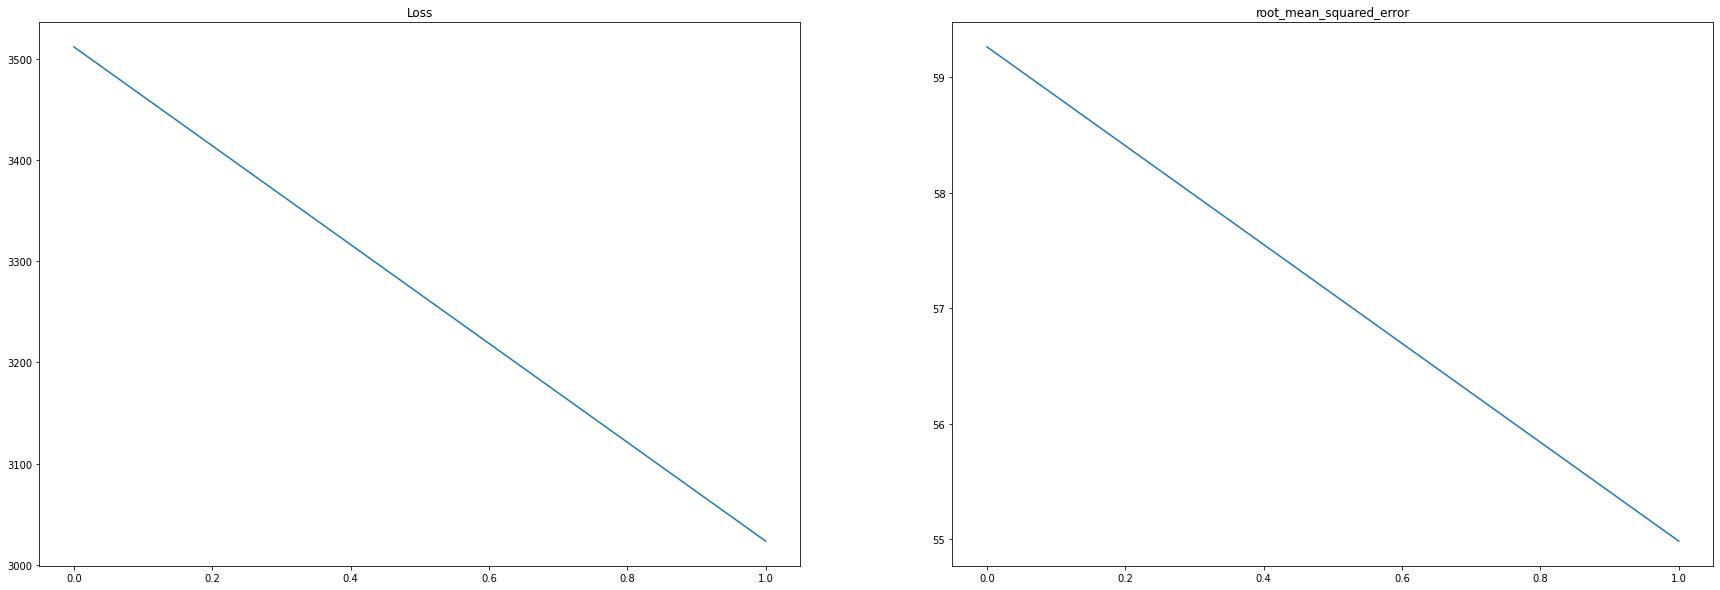

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(30)
ax1.plot(history.history["loss"])
ax1.set_title("Loss")
ax2.plot(history.history["root_mean_squared_error"])
ax2.set_title("root_mean_squared_error")
plt.show()

In [ ]:
#X_test = X_test.reshape(2,1,112,112,3)
#y_test = y_test.reshape(2,1)

In [37]:
y_pred = model.predict(X_test)

In [38]:
y_pred[0]

array([6.932923], dtype=float32)

In [39]:
y_test[0]

51.82126873

In [40]:
print("Prediction Values ")
print(y_pred)
print("*****************")
print("Real Values ")
print(y_test)

Prediction Values 
[[6.932923]
 [6.932924]]
*****************
Real Values 
[51.82126873 65.4545286 ]


In [ ]:
if (y_pred[0] >= 55 and y_pred[0] <= 70):
    plt.imshow(X_test[0])
    plt.title("Normal")
    plt.show()
elif (y_pred[0] >= 40 and y_pred[0] <= 54):
    plt.imshow(X_test[0])
    plt.title("Slightly below normal")
    plt.show()
elif (y_pred[0] >= 35 and y_pred[0] <= 39):
    plt.imshow(X_test[0])
    plt.title("Moderately below normal")
    plt.show()
    
elif (y_pred[0] < 35 ):
    plt.imshow(X_test[0])
    plt.title("Severely below normal")
    plt.show()
    